**Getting rid of warnings**

In [1]:
!pip install shutup

In [2]:
import shutup; shutup.please()

**Kaggle API token for Google Colab**

**The following steps are only for running notebook in Google Colab Environment**

In [3]:
#!pip install kaggle

In [4]:
#!mkdir ~/.kaggle
#!cp /content/kaggle.json ~/.kaggle/kaggle.json
#!chmod 600 /root/.kaggle/kaggle.json

In [5]:
#!kaggle datasets download raddar/amex-data-integer-dtypes-parquet-format

In [6]:
#! kaggle competitions download amex-default-prediction -f train_labels.csv

In [7]:
#!unzip amex-data-integer-dtypes-parquet-format.zip

In [8]:
#!unzip train_labels.csv.zip

**Importing all Required Libraries**

In [9]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
import os

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping

# Loading the Dataset

Loading the 2 most recent transactions of the customers.

In [10]:
number_of_transactions = 2

In [11]:
data = pd.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet').groupby('customer_ID').tail(number_of_transactions).set_index('customer_ID', drop=True).sort_index()
labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv').set_index('customer_ID', drop=True).sort_index()

**Merging the Training data with Labels**

In [12]:
train_df = pd.merge(data, labels, left_index=True, right_index=True)  

In [13]:
train_df.head()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2018-02-21,0.937349,0,0.019837,1.008307,0.000607,0.102985,0.0,0.007454,NaN,...,-1,-1,0,0,0.0,NaN,0,0.006346,0,0
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2018-03-13,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,NaN,...,-1,-1,0,0,0.0,NaN,0,0.002970,0,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,2018-02-06,0.878856,18,0.034558,1.005419,0.007248,0.159486,0.0,0.008733,NaN,...,-1,-1,0,0,0.0,NaN,0,0.002528,0,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,2018-03-25,0.880519,6,0.034684,1.004028,0.006911,0.165509,0.0,0.005068,NaN,...,-1,-1,0,0,0.0,NaN,0,0.003169,0,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,2018-02-09,0.866342,0,0.008318,0.818953,0.006756,NaN,0.0,0.004373,NaN,...,-1,-1,0,0,0.0,NaN,0,0.007325,0,0


In [14]:
print("The number of observations in Training Dataset is :",len(train_df))

The number of observations in Training Dataset is : 912706


In [15]:
train_df.head()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2018-02-21,0.937349,0,0.019837,1.008307,0.000607,0.102985,0.0,0.007454,NaN,...,-1,-1,0,0,0.0,NaN,0,0.006346,0,0
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2018-03-13,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,NaN,...,-1,-1,0,0,0.0,NaN,0,0.002970,0,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,2018-02-06,0.878856,18,0.034558,1.005419,0.007248,0.159486,0.0,0.008733,NaN,...,-1,-1,0,0,0.0,NaN,0,0.002528,0,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,2018-03-25,0.880519,6,0.034684,1.004028,0.006911,0.165509,0.0,0.005068,NaN,...,-1,-1,0,0,0.0,NaN,0,0.003169,0,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,2018-02-09,0.866342,0,0.008318,0.818953,0.006756,NaN,0.0,0.004373,NaN,...,-1,-1,0,0,0.0,NaN,0,0.007325,0,0


**Descriptive Statistics**

In [16]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
P_2,906552.0,0.636799,0.264131,-4.589548e-01,0.451598,0.682277,0.861331,1.010000
D_39,912706.0,6.456304,12.375271,0.000000e+00,0.000000,0.000000,9.000000,178.000000
B_1,912706.0,0.138035,0.229416,-3.571172e+00,0.009005,0.033369,0.152085,1.324059
B_2,912583.0,0.592321,0.411911,2.024839e-07,0.071785,0.813417,1.001992,1.010000
R_1,912706.0,0.102932,0.269009,5.646122e-08,0.002947,0.005901,0.008854,2.759738
...,...,...,...,...,...,...,...,...
D_142,159262.0,0.394201,0.241017,-1.453934e-02,0.199730,0.386400,0.573420,2.229368
D_143,912706.0,0.166391,0.393343,-1.000000e+00,0.000000,0.000000,0.000000,1.000000
D_144,912617.0,0.052047,0.181913,1.995319e-08,0.002752,0.005502,0.008252,1.343326
D_145,912706.0,0.633433,2.163156,-1.000000e+00,0.000000,0.000000,0.000000,53.000000


**Visualisation**

Count Plot of the Target Variable

<AxesSubplot:xlabel='target', ylabel='count'>

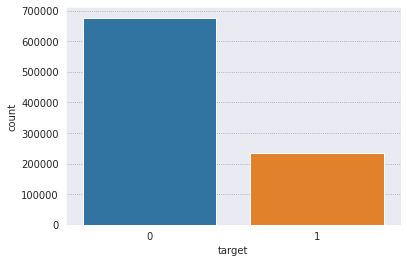

In [17]:
sns.countplot(x = 'target',data = train_df)

# Pre-Processing

**Dropping the Transaction Dates**

In [18]:
drop_cols = ['S_2'] 
train_df.drop(drop_cols, inplace=True, axis=1)

**Creating Training Labels and Data**

In [19]:
y = train_df['target']
X = train_df.drop('target', axis=1)

**Handling missing values**

Missing values are imputed with the respective column mean.

In [20]:
col_names = X.columns
imputer = SimpleImputer()
X = pd.DataFrame(imputer.fit_transform(X))  
X.columns = col_names

**Standardization**

To ascertain features are standardized by subtracting mean and scaling to unit variance.

In [21]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns) 

**Splitting into training and validation sets**

The stratify method ensures that target variable does not get improperly distrubted leading to class imbalance.

In [22]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1, shuffle=True, stratify=y, test_size=0.2)

Memory cleanup to prevent out of memory error.

In [23]:
del data, labels, X, y
gc.collect()

160

# Model Building

Models have been made in order of increasing complexity to check if a simpler model gives a better accuracy than a complex one then we select that model.

In [24]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn import metrics

**Logistic Regression**

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
clf_lr = LogisticRegression(n_jobs=1, C=1e5)
clf_lr.fit(train_X, train_y)

LogisticRegression(C=100000.0, n_jobs=1)

In [27]:
%%time
y_pred_val_lr = clf_lr.predict(val_X)
print('Accuracy on Validation set :',accuracy_score(val_y, y_pred_val_lr))
print("\n")
print(classification_report(val_y, y_pred_val_lr))

Accuracy on Validation set : 0.8930602272353759


              precision    recall  f1-score   support

           0       0.92      0.94      0.93    135354
           1       0.81      0.77      0.79     47188

    accuracy                           0.89    182542
   macro avg       0.86      0.85      0.86    182542
weighted avg       0.89      0.89      0.89    182542

CPU times: user 637 ms, sys: 132 ms, total: 769 ms
Wall time: 658 ms


Confusion Matrix : 


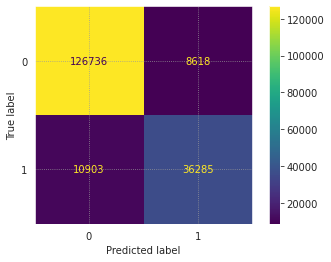

In [28]:
print('Confusion Matrix : \n',metrics.ConfusionMatrixDisplay.from_predictions(val_y, y_pred_val_lr))

Normalized Confusion Matrix :


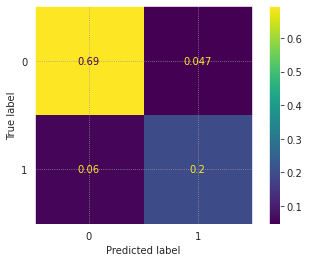

In [29]:
print('Normalized Confusion Matrix :\n',metrics.ConfusionMatrixDisplay.from_predictions(val_y, y_pred_val_lr,normalize='all'))

**Support Vector Classifier**

In [30]:
from sklearn.linear_model import SGDClassifier

In [31]:
sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
sgd.fit(train_X, train_y)

SGDClassifier(alpha=0.001, max_iter=5, random_state=42, tol=None)

In [32]:
%%time
y_pred_val_sgd = sgd.predict(val_X)
print('Accuracy on Validation set :',accuracy_score(val_y, y_pred_val_sgd))
print("\n")
print(classification_report(val_y, y_pred_val_sgd))

Accuracy on Validation set : 0.8926219719297477


              precision    recall  f1-score   support

           0       0.92      0.93      0.93    135354
           1       0.80      0.78      0.79     47188

    accuracy                           0.89    182542
   macro avg       0.86      0.86      0.86    182542
weighted avg       0.89      0.89      0.89    182542

CPU times: user 562 ms, sys: 106 ms, total: 667 ms
Wall time: 513 ms


Confusion Matrix : 


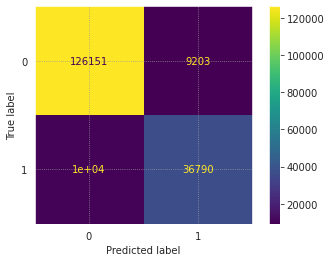

In [33]:
print('Confusion Matrix : \n',metrics.ConfusionMatrixDisplay.from_predictions(val_y, y_pred_val_sgd))

Normalized Confusion Matrix :


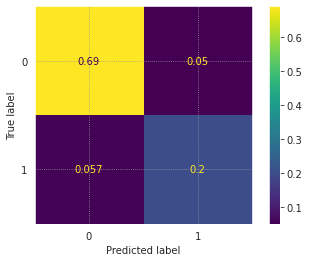

In [34]:
print('Normalized Confusion Matrix :\n',metrics.ConfusionMatrixDisplay.from_predictions(val_y, y_pred_val_sgd,normalize='all'))

**Decision Tree Classifier**

In [35]:
from sklearn.tree import DecisionTreeClassifier

In [36]:
dc = DecisionTreeClassifier(random_state=0)
dc.fit(train_X, train_y)

DecisionTreeClassifier(random_state=0)

In [37]:
%%time
y_pred_val_dc = dc.predict(val_X)
print('Accuracy on Validation set :',accuracy_score(val_y, y_pred_val_dc))
print("\n")
print(classification_report(val_y, y_pred_val_dc))

Accuracy on Validation set : 0.8573533762093107


              precision    recall  f1-score   support

           0       0.90      0.90      0.90    135354
           1       0.72      0.72      0.72     47188

    accuracy                           0.86    182542
   macro avg       0.81      0.81      0.81    182542
weighted avg       0.86      0.86      0.86    182542

CPU times: user 375 ms, sys: 939 µs, total: 376 ms
Wall time: 374 ms


Confusion Matrix : 


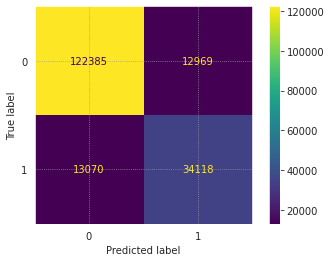

In [38]:
print('Confusion Matrix : \n',metrics.ConfusionMatrixDisplay.from_predictions(val_y, y_pred_val_dc))

Normalized Confusion Matrix :


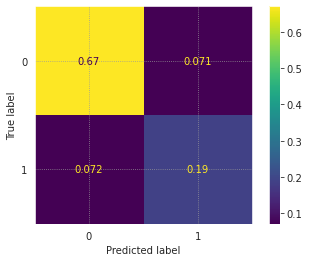

In [39]:
print('Normalized Confusion Matrix :\n',metrics.ConfusionMatrixDisplay.from_predictions(val_y, y_pred_val_dc,normalize='all'))

**Light GBM Classifier**

In [40]:
from lightgbm import LGBMClassifier

In [41]:
lgbm = LGBMClassifier()
lgbm.fit(train_X, train_y)

LGBMClassifier()

In [42]:
%%time
y_pred_val_lgbm = lgbm.predict(val_X)
print('Accuracy on Validation set :',accuracy_score(val_y, y_pred_val_lgbm))
print("\n")
print(classification_report(val_y, y_pred_val_lgbm))

Accuracy on Validation set : 0.8966977462720908


              precision    recall  f1-score   support

           0       0.93      0.93      0.93    135354
           1       0.80      0.80      0.80     47188

    accuracy                           0.90    182542
   macro avg       0.87      0.87      0.87    182542
weighted avg       0.90      0.90      0.90    182542

CPU times: user 2.19 s, sys: 2.04 ms, total: 2.19 s
Wall time: 1.27 s


Confusion Matrix : 


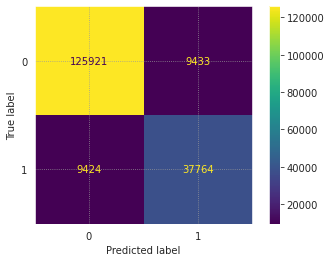

In [43]:
print('Confusion Matrix : \n',metrics.ConfusionMatrixDisplay.from_predictions(val_y, y_pred_val_lgbm))

Normalized Confusion Matrix :


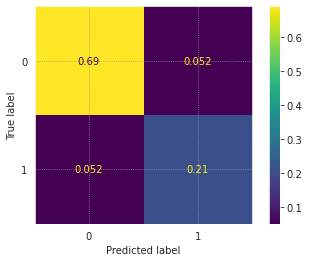

In [44]:
print('Normalized Confusion Matrix :\n',metrics.ConfusionMatrixDisplay.from_predictions(val_y, y_pred_val_lgbm,normalize='all'))

**MLP Classifier**

In [45]:
from sklearn.neural_network import MLPClassifier

In [46]:
mlp = MLPClassifier(random_state=1, max_iter=300)
mlp.fit(train_X, train_y)

MLPClassifier(max_iter=300, random_state=1)

In [47]:
%%time
y_pred_val_mlp = mlp.predict(val_X)
print('Accuracy on Validation set :',accuracy_score(val_y, y_pred_val_mlp))
print("\n")
print(classification_report(val_y, y_pred_val_mlp))

Accuracy on Validation set : 0.8964183585147528


              precision    recall  f1-score   support

           0       0.93      0.93      0.93    135354
           1       0.81      0.79      0.80     47188

    accuracy                           0.90    182542
   macro avg       0.87      0.86      0.86    182542
weighted avg       0.90      0.90      0.90    182542

CPU times: user 779 ms, sys: 159 ms, total: 938 ms
Wall time: 610 ms


Confusion Matrix : 


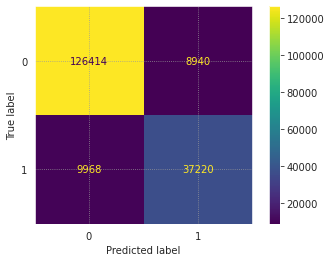

In [48]:
print('Confusion Matrix : \n',metrics.ConfusionMatrixDisplay.from_predictions(val_y, y_pred_val_mlp))

Normalized Confusion Matrix :


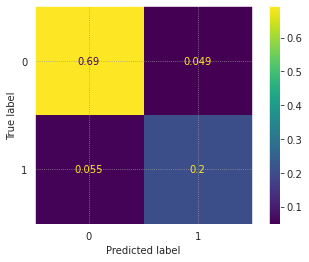

In [49]:
print('Normalized Confusion Matrix :\n',metrics.ConfusionMatrixDisplay.from_predictions(val_y, y_pred_val_mlp,normalize='all'))

**Listing Accuracies on Validation Data by Models so far**

In [50]:
print('\nAccuracy of Logistic Regression :',accuracy_score(val_y, y_pred_val_lr))
print('\nAccuracy of Support Vector :',accuracy_score(val_y, y_pred_val_sgd))
print('\nAccuracy of Decision Tree :',accuracy_score(val_y, y_pred_val_dc))
print('\nAccuracy of MLP Classifier :',accuracy_score(val_y, y_pred_val_mlp))
print('\nAccuracy Light GBM Classifier :',accuracy_score(val_y, y_pred_val_lgbm))


Accuracy of Logistic Regression : 0.8930602272353759

Accuracy of Support Vector : 0.8926219719297477

Accuracy of Decision Tree : 0.8573533762093107

Accuracy of MLP Classifier : 0.8964183585147528

Accuracy Light GBM Classifier : 0.8966977462720908


# Inferences

The best accuracy is obtained using Light GBM Classifier.

# Points for Future Scope


*   Using PCA during Pre-processing to select the important contributing factors
*   Using a Custom Neural Network
